In [1]:
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import json

import analysis_helpers as h
reload(h)

## get standardized object list
categories = ['bird','car','chair','dog']
obj_list = []
for cat in categories:
    for i,j in h.objcat.iteritems():
        if j==cat:
            obj_list.append(i)        

In [2]:
# directory & file hierarchy
iterationName = 'pilot2'
exp_path = './'
analysis_dir = os.getcwd()
data_dir = os.path.abspath(os.path.join(os.getcwd(),'../../..','data',exp_path))
exp_dir = './'
sketch_dir = os.path.abspath(os.path.join(os.getcwd(),'../../..','analysis',exp_path,'sketches','pilot2'))

In [3]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['sketchpad_basic_recog']

stimdb = conn['stimuli']
stimcoll = stimdb['sketchpad_basic_pilot2_sketches']

In [4]:
## How many sketches have been retrieved at least once? equivalent to: coll.find({'numGames':{'$exists':1}}).count()
x = stimcoll.find({'numGames':{'$gte':0}}).count()
y = coll.count()
print '{} sketches in the stimuli db that have been retrieved at least once'.format(x)
print '{} records in the recognition experiment database'.format(y)
### "pilot2" of recog experiment run on Sunday April 22 2018
print '{} unique workers.'.format(len(coll.find({'iterationName': {'$in': ['pilot0', 'pilot1', 'pilot2']}}).distinct('wID')))

2849 sketches in the stimuli db that have been retrieved at least once
27374 records in the recognition experiment database
312 unique workers.


### preprocess recognition task data

In [202]:
## retrieve records from db
## notes: 
## pilot0 = no feedback onscreen
## pilot1 = bonus point counter onscreen


## make lists from db
gameID = []
target = []
choice = []
correct = []
correct_class = []
rt = []
fname = []

d1 = []
d2 = []
d3 = []
target_category = []
chosen_category = []
condition = []
drawDuration = []
original_gameID = []
viewer_correct = []
viewer_choice = []
viewer_RT = []
mean_intensity = []
num_strokes = []

bad_sessions = ['1571-00d11ddf-96e7-4aae-ba09-1a338b328c0e','9770-2f360e9a-7a07-4026-9c36-18b558c1da21']
a = coll.find({'iterationName': {'$in': ['pilot0', 'pilot1', 'pilot2']}}).sort('gameID').batch_size(50)

counter = 0
for rec in a:
    if rec['gameID'] not in bad_sessions:
        try:
            if counter%500==0:
                print '{} out of {} records analyzed.'.format(counter,a.count())
            if rec['target'] is not None:
                gameID.append(rec['gameID'])
                target.append(rec['target'])
                choice.append(rec['choice'])
                correct.append(rec['correct'])
                rt.append(rec['rt'])
                f = rec['sketch'].split('/')[-1]
                fname.append(f)
                chosen_category.append(h.objcat[rec['choice']])

                ## match up with corresponding record in stimuli collection
                b = stimcoll.find({'fname_no_target':f})[0]
                assert stimcoll.find({'fname_no_target':f}).count()==1
                d1.append(b['Distractor1'])
                d2.append(b['Distractor2'])
                d3.append(b['Distractor2'])
                target_category.append(b['category'])
                correct_class.append(h.objcat[rec['choice']]==b['category'])
                condition.append(b['condition'])
                drawDuration.append(b['drawDuration'])
                original_gameID.append(b['gameID'])
                viewer_correct.append(b['outcome'])
                viewer_choice.append(b['response'])
                viewer_RT.append(b['viewerRT'])
                mean_intensity.append(b['mean_intensity'])  
                num_strokes.append(b['numStrokes'])    
                counter += 1
        except:
            print 'Something went wrong with {} {}'.format(rec['gameID'],rec['trialNum'])
            pass

In [6]:
## organize data into dataframe
X = pd.DataFrame([gameID,target,choice,correct,rt,fname,d1,d2,d3,target_category,chosen_category,condition,drawDuration, \
                 original_gameID,viewer_correct,viewer_choice,viewer_RT,mean_intensity,num_strokes,correct_class])
X = X.transpose()
X.columns = ['gameID','target','choice','correct','rt','fname','d1','d2','d3','target_category','chosen_category','condition','drawDuration', \
            'original_gameID','viewer_correct','viewer_choice','viewer_RT','mean_intensity','num_strokes','correct_class']
print '{} annotations saved.'.format(X.shape[0])

## save proto version of X as X0
X0 = X

27152 annotations saved.


In [216]:
## remove NaN rows from data matrix (no target recorded)
X = X[X['target'].isin(obj_list)]

## filter out games that were particularly low accuracy 
X['correct']=pd.to_numeric(X['correct'])
acc = X.groupby('gameID')['correct'].mean().reset_index()
acc_games = acc[acc['correct']>0.25]['gameID'] ## amounts to around 6% of data ## np.percentile(acc['correct'].values,6)
X = X[X['gameID'].isin(acc_games)]

## filter out responses that took too long, or too short
too_fast = 1000
too_slow = 30000
X = X[(X['rt']>=too_fast) & (X['rt']<=too_slow)]

print '{} annotations retained.'.format(X.shape[0])

24976 annotations retained.


In [217]:
## save out to CSV
X.to_csv('./sketchpad_basic_recog_group_data_2.csv')

### basic performance measures 

In [218]:
## load in CSV
X = pd.read_csv('./sketchpad_basic_recog_group_data_2.csv')

In [219]:
if not os.path.exists('./plots'):
    os.makedirs('./plots')

In [220]:
## how many sessions (proxy for number of observers) do we have?
print 'Number of sessions: {}'.format(len(np.unique(X.gameID.values)))

Number of sessions: 422


Text(0,0.5,u'number of sketches')

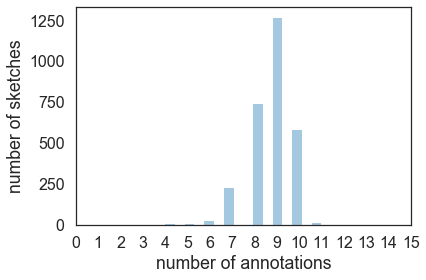

In [221]:
### histogram of annotations per sketch
x = X.groupby('fname')['gameID'].count().reset_index()
h = sns.distplot(x['gameID'].values,bins=16,kde=False)
plt.xlim(0,15)
xt = plt.xticks(np.arange(0,16))
plt.xlabel('number of annotations')
plt.ylabel('number of sketches')

In [222]:
## what is object-level accuracy broken out condition?
print X.groupby('condition')['correct'].apply(lambda x: np.mean(x))

## what is class-level accuracy?
print X.groupby('condition')['correct_class'].apply(lambda x: np.mean(x))


condition
closer     0.567835
further    0.383790
Name: correct, dtype: float64
condition
closer     0.984680
further    0.979875
Name: correct_class, dtype: float64


In [223]:
print X.groupby('condition')['correct'].count()
print X.groupby('condition')['correct'].sum()

condition
closer     12206
further    12770
Name: correct, dtype: int64
condition
closer     6931
further    4901
Name: correct, dtype: int64


In [224]:
#### are the two proportions different?
p1 = X.groupby('condition')['correct'].apply(lambda x: np.mean(x))['closer']
p2 = X.groupby('condition')['correct'].apply(lambda x: np.mean(x))['further']
n1 = X.groupby('condition')['correct'].count()['closer']
n2 = X.groupby('condition')['correct'].count()['further']
p_hat = ((n1*p1)+(n2*p2))/(n1+n2)
z = (p1 - p2) / (np.sqrt(p_hat * (1 - p_hat) * (1/n1 + 1/n2)))
print 'Z stat for difference between two proportions (binomially distributed): {}'.format(z)

Z stat for difference between two proportions (binomially distributed): 29.1189416267


In [225]:
import scipy
p = scipy.stats.binom_test(p1*n1, n=n1, p=1/32, alternative='two-sided')
print 'Closer proportion diff from chance? p = {}'.format(p)

p = scipy.stats.binom_test(p2*n2, n=n2, p=1/32, alternative='two-sided')
print 'Further proportion diff from chance? p = {}'.format(p)

Closer proportion diff from chance? p = 0.0
Further proportion diff from chance? p = 0.0


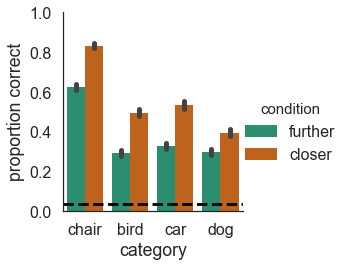

In [271]:
## plot recognition accuracy by condition
sns.set_context('poster')
fig = plt.figure(figsize=(4,4))
sns.factorplot(y='correct',
                x='target_category',
                hue='condition',
                data=X,kind='bar',palette='Dark2')
plt.ylim([0,1])
plt.ylabel('proportion correct')
plt.xlabel('category')
h = plt.axhline(1/32,linestyle='dashed',color='black')
plt.savefig('./plots/accuracy_by_category_and_condition.pdf')
plt.close(fig)

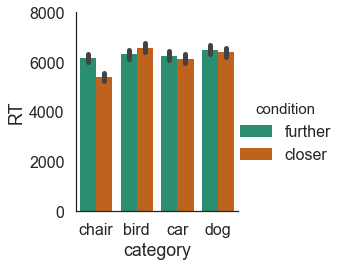

In [270]:
## plot RT by condition
sns.set_context('poster')
# fig = plt.figure(figsize=(8,8))
fig = plt.figure(figsize=(4,4))
sns.factorplot(y='rt',
                x='target_category',
                hue='condition',
                data=X,kind='bar',palette='Dark2')
plt.ylim([0,8000])
plt.ylabel('RT')
plt.xlabel('category')
plt.savefig('./plots/RT_by_category_and_condition.pdf')
plt.close(fig)

In [228]:
print X.groupby('condition')['rt'].apply(lambda x: np.median(x))

condition
closer     4525.5
further    4672.0
Name: rt, dtype: float64


In [229]:
# X.groupby(['gameID','condition'])['correct'].apply(lambda x: np.mean(x))
# X.groupby(['gameID'])['correct'].apply(lambda x: np.mean(x))

In [272]:
## plot accuracy by condition and game (individual differences)
#X.groupby(['gameID','condition'])['correct'].apply(lambda x: np.mean(x))

## subset by full games only
all_games = np.unique(X.gameID.values)
full_games = [i for i in all_games if np.sum(X['gameID']==i)>50]
_X = X[X['gameID'].isin(full_games)]

game_acc_close = _X[_X['condition']=='closer'].groupby('gameID')['correct'].apply(lambda x: np.mean(x))
game_acc_far = _X[_X['condition']=='further'].groupby('gameID')['correct'].apply(lambda x: np.mean(x))
fig = plt.figure(figsize=(6,6))
plt.scatter(game_acc_close,game_acc_far)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],linestyle='dashed')
plt.title('accuracy by condition and game')
plt.xlabel('close accuracy')
plt.ylabel('far accuracy')
plt.savefig('./plots/accuracy_by_condition_and_game.pdf')
plt.close(fig)

In [232]:
sns.set_context('poster')
objs = np.unique(X['target'].values)
objs = [o for o in objs if o is not None]
obj_acc_close = X[X['condition']=='closer'].groupby('target')['correct'].apply(lambda x: np.mean(x))
obj_acc_far = X[X['condition']=='further'].groupby('target')['correct'].apply(lambda x: np.mean(x))
fig = plt.figure(figsize=(6,6))
plt.scatter(obj_acc_close,obj_acc_far,color='gray')
for i, txt in enumerate(objs):
    plt.annotate(txt, (obj_acc_close[i],obj_acc_far[i]))
plt.xlim([0,1])
plt.ylim([0,1]) 
plt.plot([0,1],[0,1],linestyle='dashed',color='gray')
plt.xlabel('close accuracy',fontsize=30)
plt.ylabel('far accuracy',fontsize=30)
# plt.title('accuracy by condition and object',fontsize=30)
plt.savefig('./plots/accuracy_by_condition_and_object.pdf')
plt.close(fig)

In [233]:
objs = np.unique(X['target'].values)
objs = [o for o in objs if o is not None]
obj_acc_close = X[X['condition']=='closer'].groupby('target')['rt'].apply(lambda x: np.mean(x))
obj_acc_far = X[X['condition']=='further'].groupby('target')['rt'].apply(lambda x: np.mean(x))
fig = plt.figure(figsize=(6,6))
plt.scatter(obj_acc_close,obj_acc_far)
# for i, txt in enumerate(objs):
#     plt.annotate(txt, (obj_acc_close[i],obj_acc_far[i]))

plt.xlim([0,15000])
plt.ylim([0,15000])
plt.plot([0,15000],[0,15000],linestyle='dashed')
plt.xlabel('close RT')
plt.ylabel('far RT')
plt.title('RT by condition and object')
plt.savefig('./plots/RT_by_condition_and_object.pdf')
plt.close(fig)

In [234]:
## subset by full games only
all_games = np.unique(X.gameID.values)
full_games = [i for i in all_games if np.sum(X['gameID']==i)>50]
_X = X[X['gameID'].isin(full_games)]

game_acc_close = _X[_X['condition']=='closer'].groupby('gameID')['rt'].apply(lambda x: np.median(x))
game_acc_far = _X[_X['condition']=='further'].groupby('gameID')['rt'].apply(lambda x: np.median(x))
fig = plt.figure(figsize=(6,6))
plt.scatter(game_acc_close,game_acc_far)
# plt.xlim([0,20000])
# plt.ylim([0,20000])
# plt.plot([0,20000],[0,20000],linestyle='dashed')
plt.title('RT by condition and game')
plt.xlabel('close RT')
plt.ylabel('far RT')
plt.savefig('./plots/RT_by_condition_and_game.pdf')
plt.close(fig)

In [235]:
## subset by full games only
all_games = np.unique(X.gameID.values)
full_games = [i for i in all_games if np.sum(X['gameID']==i)>50]
_X = X[X['gameID'].isin(full_games)]

acc = _X.groupby('gameID')['correct'].apply(lambda x: np.mean(x))
rt = _X.groupby('gameID')['rt'].apply(lambda x: np.mean(x))
fig = plt.figure(figsize=(6,6))
plt.scatter(acc,rt)
plt.xlabel('accuracy')
plt.ylabel('RT')
plt.title('RT vs. accuracy by game')
plt.savefig('./plots/RT_vs_accuracy_by_game.pdf')
plt.close(fig)

In [ ]:
# Y = X.groupby(['target','condition'])['correct'].apply(lambda x: np.mean(x))

### make confusion matrix

In [245]:
import analysis_helpers as h
reload(h)

## get standardized object list
categories = ['bird','car','chair','dog']
obj_list = []
for cat in categories:
    for i,j in h.objcat.iteritems():
        if j==cat:
            obj_list.append(i)        

##### all sketches

In [246]:
## initialize confusion matrix
confusion = np.zeros((len(obj_list),len(obj_list)))

## generate confusion matrix by incrementing in each cell
for i,d in X.iterrows():
    targ_ind = obj_list.index(d['target'])
    choice_ind = obj_list.index(d['choice'])
    confusion[targ_ind,choice_ind] += 1
    
## normalized confusion matrix    
normed = np.zeros((len(obj_list),len(obj_list)))
for i in np.arange(len(confusion)):
    normed[i,:] = confusion[i,:]/np.sum(confusion[i,:])    
    
## plot confusion matrix
from matplotlib import cm
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
cax = ax.matshow(normed,vmin=0,vmax=1,cmap=cm.viridis)
plt.xticks(range(len(normed)), obj_list, fontsize=12,rotation='vertical')
plt.yticks(range(len(normed)), obj_list, fontsize=12)
plt.colorbar(cax,shrink=0.8)
plt.tight_layout()
plt.savefig('./plots/confusion_matrix_all.pdf')
plt.close(fig)

##### divided by condition

In [247]:
conds = ['closer','further']

for cond in conds:
    ## initialize confusion matrix 
    confusion = np.zeros((len(obj_list),len(obj_list)))

    _X = X[X['condition']==cond]
    ## generate confusion matrix by incrementing in each cell
    for i,d in _X.iterrows():
        targ_ind = obj_list.index(d['target'])
        choice_ind = obj_list.index(d['choice'])
        confusion[targ_ind,choice_ind] += 1

    ## normalized confusion matrix    
    normed = np.zeros((len(obj_list),len(obj_list)))
    for i in np.arange(len(confusion)):
        normed[i,:] = confusion[i,:]/np.sum(confusion[i,:])    

    ## plot confusion matrix
    from matplotlib import cm
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    cax = ax.matshow(normed,vmin=0,vmax=1,cmap=cm.viridis)
    plt.xticks(range(len(normed)), obj_list, fontsize=12,rotation='vertical')
    plt.yticks(range(len(normed)), obj_list, fontsize=12)
    plt.colorbar(cax,shrink=0.8)
    plt.tight_layout()
    plt.savefig('./plots/confusion_matrix_{}.pdf'.format(cond))
    plt.close(fig)

##### plot difference between close and far conditions

In [248]:
conds = ['closer','further']
normed = np.zeros((len(obj_list),len(obj_list),2))

for k,cond in enumerate(conds):
    ## initialize confusion matrix 
    confusion = np.zeros((len(obj_list),len(obj_list)))

    _X = X[X['condition']==cond]
    ## generate confusion matrix by incrementing in each cell
    for i,d in _X.iterrows():
        targ_ind = obj_list.index(d['target'])
        choice_ind = obj_list.index(d['choice'])
        confusion[targ_ind,choice_ind] += 1

    ## normalized confusion matrix    
    for i in np.arange(len(confusion)):
        normed[i,:,k] = confusion[i,:]/np.sum(confusion[i,:])    

## plot difference in confusion matrix
from matplotlib import cm
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
cax = ax.matshow(normed[:,:,0]-normed[:,:,1],vmin=-0.2,vmax=0.2,cmap=cm.BrBG)
plt.xticks(range(len(normed)), obj_list, fontsize=12,rotation='vertical')
plt.yticks(range(len(normed)), obj_list, fontsize=12)
plt.colorbar(cax,shrink=0.8)
plt.tight_layout()
plt.savefig('./plots/confusion_matrix_close_minus_far.pdf')
plt.close(fig)

# save out to npy 
np.save('./human_confusion.npy',normed)

Text(0.5,1,u'diff diagonal')

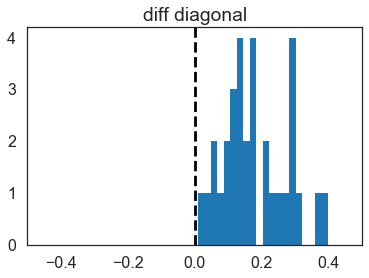

In [249]:
## plot diagonals of diff between confusion matrices
h = plt.hist(np.diagonal(normed[:,:,0]-normed[:,:,1]),20)
plt.xlim(-0.5,0.5)
plt.axvline(0,linestyle='dashed',color='black')
plt.title('diff diagonal')

In [250]:
## save out object order 
x = pd.DataFrame([obj_list])
x = x.transpose()
x.columns = ['object']
x.to_csv('./human_confusion_object_order.csv')

In [251]:
## save out idealized human confusion 
def gen_block_diagonal(num_blocks,num_objs):
    '''
    num_blocks = how many square blocks do you want?
    num_objs = number of rows in resulting matrix (equal to number of columns)
    '''
    assert num_objs%num_blocks==0
    tmp = np.zeros([num_objs,num_objs])
    ub = map(int,np.linspace(0,num_objs,num_blocks+1)[1:])
    lb = map(int,np.linspace(0,num_objs,num_blocks+1)[:-1])
    partitions = zip(lb,ub)
    for l,u in partitions:
        tmp[l:u,l:u] = 1
    out = np.zeros([num_objs,num_objs])
    for i,row in enumerate(tmp):
        out[i] = row/np.sum(row)
    return out

idealized = np.zeros([32,32,2])
idealized[:,:,0] = np.identity(32)
idealized[:,:,1] = gen_block_diagonal(4,32)

# save out to npy 
np.save('./human_confusion_idealized.npy',idealized)

#### prep jsons for evaluation by passing forward to RSA

Format for json is a dictionary of dictionaries, where each top-level key refers to one of the renders, e.g. "trial_20_cuckoo". For each render, you can look up the similarity with each sketch, referenced with an abbreviated ID taken by trimming the last 12-character string, and appending an underscore, and the trial number. E.g., 'gameID_9903-d6e6a9ff-a878-4bee-b2d5-26e2e239460a_trial_9.npy' ==> '26e2e239460a_9'

In [242]:
import json

## sample json paths
json_path_prefix = '../models/refModule/json/'
json_file = 'strict-similarity-pragmatics-fixedpose-augmented-splitbycontext_conv4_2.json'
json_path = os.path.join(json_path_prefix,json_file)

def load_json(json_path):
    with open(json_path) as fp:
        data = json.load(fp)  
    return data

## build dictionary to look up the appropriate render ID to use to associate with each sketch
data = load_json(json_path)
    
obj_to_render = dict(zip([i.split('_')[-1] for i in data.keys()], data.keys()))  
render_to_obj = dict(zip(data.keys(),[i.split('_')[-1] for i in data.keys()]))  

In [243]:
def simplify_sketch(path): ## example path: 'gameID_9903-d6e6a9ff-a878-4bee-b2d5-26e2e239460a_trial_9.npy' ==> '26e2e239460a_9'
    path = '_'.join(os.path.splitext(os.path.basename(path))[0].split('_')[1:])
    path = path.split('-')[-1]
    path = path.replace('_trial', '')
    return path

def add_simplified_ids(X):
    ## add renderID and sketchID to dataframen
    renderID = []
    sketchID = []
    for i,d in X.iterrows():
        renderID.append(obj_to_render[d['target']])
        sketchID.append(simplify_sketch(d['fname']))
    X['renderID'] = renderID
    X['sketchID'] = sketchID    
    return X

In [244]:
## add simplified id's
X = add_simplified_ids(X)

## save out again to csv with these additional columns added
X.to_csv('./sketchpad_basic_recog_group_data_2_augmented.csv',index=False)

## load in normalized confusion matrix
confusion = np.load('./human_confusion.npy')
close_con = confusion[:,:,0]
far_con = confusion[:,:,1]

In [208]:
## get confusion matrix lookup table for sketches from each condition

## close
rows = [i for i in close_con]
close_lookup = dict(zip(obj_list, [dict(zip(obj_list,r)) for r in rows])) 

## far
rows = [i for i in far_con]
far_lookup = dict(zip(obj_list, [dict(zip(obj_list,r)) for r in rows])) 

## list of 3d rendered objects
render_list = data.keys()

In [212]:
## generate big json dictionary of dictionaries
out_json = {}
for i,this_render in enumerate(render_list):
    print i, this_render
    out_json[this_render] = {}
    for i,d in X.iterrows():
        if d['condition'] == 'closer':
            which_dict = close_lookup
        elif d['condition'] == 'further':
            which_dict = far_lookup
        this_sketch = d['sketchID']
        this_target = d['target']
        similarity = which_dict[this_target][render_to_obj[this_render]]
        out_json[this_render][this_sketch] = similarity

In [210]:
## output json in the same format as the other similarity jsons
output_path = '../models/refModule/json/similarity-human.json'
with open(output_path, 'wb') as fp:
    json.dump(out_json, fp)

### explore how different measures of cost relate to similarity

In [ ]:
## load in normalized confusion matrix
confusion = np.load('./human_confusion.npy')
close_con = confusion[:,:,0]
far_con = confusion[:,:,1]

In [ ]:
## define dictionaries from objects to the similarities
sim_close = dict(zip(obj_list,np.diag(close_con)))
sim_far = dict(zip(obj_list,np.diag(far_con)))

In [264]:
## add human similarity btw sketch and target object as column to main csv
human_similarity = []
for i,d in X.iterrows():
    if d['condition']=='closer':
        human_similarity.append(sim_close[d['target']])
    elif d['condition']=='further':
        human_similarity.append(sim_far[d['target']])
X['human_similarity'] = human_similarity   
X.to_csv('./sketchpad_basic_recog_group_data_2_augmented.csv')

### remove cost outliers and save out 

In [266]:
## load augmented data and filter out outliers
X = pd.read_csv('./sketchpad_basic_recog_group_data_2_augmented.csv')

def remove_outliers(X,column):
    mu = np.mean(X[column].values)
    sd = np.std(X[column].values)
    thresh = mu + 5*sd        
    X = X.drop(X[X[column] > thresh].index)
    return X
 
X = remove_outliers(X,'drawDuration')    
X = remove_outliers(X,'mean_intensity')
X = remove_outliers(X,'num_strokes')

print X.shape

splits = ['splitbyobject','alldata']
for split in splits:
    ### subset drawing data csv by sketches that are accounted for here (i.e., that were not cost outliers)
    D = pd.read_csv('../models/bdaInput/sketchData_fixedPose_{}_sketchUnrollSynthetic_pilot2.csv'.format(split))
    print D.shape

    remaining_sketches = list(np.unique(X['sketchID'].values))
    _D = D[D['sketchLabel'].isin(remaining_sketches)]
    print _D.shape
    _D.to_csv('../models/bdaInput/sketchData_fixedPose_{}_sketchUnrollSynthetic_pilot2_costOutliersRemoved.csv'.format(split))

(24708, 23)
(555, 8)
(546, 8)
(2682, 8)
(2653, 8)


In [182]:
def sigmoid(x,k=1,x0=0.5):
    return 1 / (1 + np.exp(-k * (x - x0)))

def add_rescaled_metric(X,metric,transform='maxnorm',k=5):
    '''
    input: X is a data frame, metric is the name of one of the (cost) metrics that you want to scale between 0 and 1
            transform options include:
                :'maxnorm', which means dividing each value by maximum in list
                :'minmaxnorm', look at it
                :'sigmoid', which means passing each value through logistic function with mean
    output: X with additional column that has the rescaled metric
    '''
    if metric=='drawDuration': ## if handling drawDuration, log first -- no wait, maybe not 
#         vals = np.log(X[metric].values+1e-6)        
        vals = X[metric].values
    else:
        vals = X[metric].values
    X['vals'] = vals
    if transform=='maxnorm':
        top_val = np.max(vals)
        rescaled_val = []
        for i,d in X.iterrows():
            rescaled_val.append(d['vals']/top_val)
    elif transform=='minmaxnorm':
        bottom_val = np.min(vals)
        top_val = np.max(vals)
        rescaled_val = []
        for i,d in X.iterrows():
            rescaled_val.append((d['vals']-bottom_val)/(top_val-bottom_val))        
    elif transform=='sigmoid':
        median_val = np.median(vals)
        rescaled_val = []
        for i,d in X.iterrows():
            rescaled_val.append(sigmoid(d['vals'],k=k,x0=median_val))
    X['rescaled_{}'.format(metric)] = rescaled_val          
    return X

In [183]:
X = add_rescaled_metric(X,'num_strokes',transform='minmaxnorm')
X = add_rescaled_metric(X,'mean_intensity',transform='minmaxnorm')
X = add_rescaled_metric(X,'drawDuration',transform='minmaxnorm')

In [186]:
# cost_metric = 'rescaled_drawDuration' ## cost metrics options: 'num_strokes','mean_intensity','drawDuration'
# fig = plt.figure(figsize=(6,6))
# sns.regplot(data=X,
#            x='human_similarity', ## similarity
#            y=cost_metric,
#            robust=False,
#            ci=None,
#            logistic=True)

In [187]:
xformatter = dict(zip(['drawDuration','num_strokes','mean_intensity'],['draw duration','number of strokes','mean intensity']))

metrics = ['drawDuration','num_strokes','mean_intensity']
for i,_metric in enumerate(metrics):
    metric = 'rescaled_{}'.format(_metric)
    f = X[X['condition']=='further'][metric].values
    c = X[X['condition']=='closer'][metric].values

    fig = plt.figure(figsize=(5,5))
    h = sns.distplot(f,color=[0.8,0.2,0.2],label='far')
    h = sns.distplot(c,color=[0.2,0.2,0.8],label='close')
    plt.ylim([0,6])
    plt.legend()
    plt.xlim([0,1])
    plt.xlabel(metric.split('_')[1])
    plt.ylabel('density')
    plt.xlabel('{} (normalized)'.format(xformatter[_metric]))
    plt.tight_layout()
    plt.savefig('./plots/cost_density_by_condition_{}.pdf'.format(metric.split('_')[1]))
    plt.close(fig)

In [188]:
## resave out csv, augmented with rescaled cost parameters
X.to_csv('./sketchpad_basic_recog_group_data_2_augmented.csv')

(0.467312887872643, 0.0)
(0.7180404069831545, 0.0)
(0.44899363471190923, 0.0)


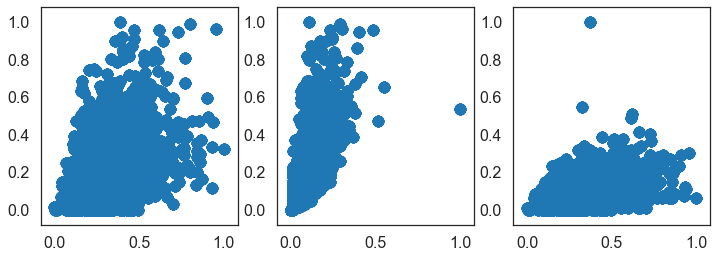

In [189]:
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.scatter(X['rescaled_mean_intensity'],X['rescaled_drawDuration'])
plt.subplot(132)
plt.scatter(X['rescaled_num_strokes'],X['rescaled_drawDuration'])
plt.subplot(133)
plt.scatter(X['rescaled_mean_intensity'],X['rescaled_num_strokes'])

print stats.pearsonr(X['rescaled_mean_intensity'],X['rescaled_drawDuration'])
print stats.pearsonr(X['rescaled_num_strokes'],X['rescaled_drawDuration'])
print stats.pearsonr(X['rescaled_mean_intensity'],X['rescaled_num_strokes'])

# print stats.pearsonr(X['rescaled_mean_intensity'],X['human_similarity'])
# print stats.pearsonr(X['rescaled_num_strokes'],X['human_similarity'])
# print stats.pearsonr(X['rescaled_drawDuration'],X['human_similarity'])

### generate cost dictionaries to try out with pragmatics model


In [190]:
## generate cost dictionaries to try out with pragmatics model
print len(np.unique(X['sketchID'].values))
sketchID_list = np.unique(X['sketchID'].values)
metrics = ['drawDuration','mean_intensity','num_strokes']

for metric in metrics:    
    print metric
    #### draw duration
    cost_json = {}
    for i,d in enumerate(sketchID_list):
        assert len(np.unique(X[X['sketchID']==d]['rescaled_{}'.format(metric)].values))==1
        cost_json[d] = X[X['sketchID']==d]['rescaled_{}'.format(metric)].values[0]    

    ## output json in the same format as the other cost json
    output_path = '../models/refModule/json/costs-fixedPose96-{}.json'.format(metric)
    with open(output_path, 'wb') as fp:
        json.dump(cost_json, fp)
        

2818
drawDuration
mean_intensity
num_strokes


### generate condition-lookup.json to be able to pair sketches with condition


In [177]:
## generate condition-lookup.json to be able to pair sketches with condition
cond_json = {}
sketchID_list = np.unique(X['sketchID'].values)
for i,d in enumerate(sketchID_list):
    cond = X[X['sketchID']==d]['condition'].values[0]
    obj = X[X['sketchID']==d]['target'].values[0]
    cond_json[d] = '{}_{}'.format(cond,obj)
    
## output json in the same format as the other cost json
output_path = '../models/bdaInput/condition-lookup.json'
with open(output_path, 'wb') as fp:
    json.dump(cond_json, fp)
    

In [178]:
u = load_json('../models/bdaInput/condition-lookup.json')
print len(u)

2818


### Get MAP param values from bdaOutput

In [ ]:
path_to_bdaoutput = '../models/bdaOutput'

In [ ]:
marp = 'human_combined_cost_alldataParams.csv'
pragmatic_cost = pd.read_csv(os.path.join(path_to_bdaoutput,marp))
pragmatic_cost

In [ ]:
marp = 'human_S0_cost_alldataParams.csv'
literal_cost = pd.read_csv(os.path.join(path_to_bdaoutput,marp))
literal_cost

In [ ]:
marp = 'human_combined_nocost_alldataParams.csv'
pragmatic_nocost = pd.read_csv(os.path.join(path_to_bdaoutput,marp))
pragmatic_nocost

In [ ]:
marp = 'human_S0_nocost_alldataParams.csv'
literal_nocost = pd.read_csv(os.path.join(path_to_bdaoutput,marp))
literal_nocost

In [ ]:
prag_zoo = ['pragmatic','pragmatic','literal','literal']
prod_zoo = ['cost','nocost','cost','nocost']
perc_zoo = ['human','human','human','human']
ll = [pragmatic_cost['logLikelihood'].values[0],
      pragmatic_nocost['logLikelihood'].values[0],      
      literal_cost['logLikelihood'].values[0],
      literal_nocost['logLikelihood'].values[0]]
LL = pd.DataFrame([ll,prag_zoo,prod_zoo,perc_zoo])
LL = LL.transpose()
LL.columns=['logLikelihood','pragmatics','production','perception']

In [ ]:
sns.factorplot(data=LL,x='pragmatics',y='logLikelihood',hue='production',kind='bar',palette='Paired')
plt.ylabel('log likelihood')
plt.ylim([-14000,0])
plt.savefig('./plots/loglikelihood_models_fullaxes.pdf')
plt.close()

sns.factorplot(data=LL,x='pragmatics',y='logLikelihood',hue='production',kind='bar',palette='Paired')
plt.ylabel('log likelihood')
plt.ylim([-12000,-11800])
plt.savefig('./plots/loglikelihood_models_zoomed.pdf')
plt.close()

In [ ]:
pragmatic_cost

In [ ]:
param_table = pd.concat([pragmatic_cost,pragmatic_nocost,literal_cost,literal_nocost],axis=0)\
[['perception','pragmatics','production','alpha','simScaling','pragWeight','costWeight','logLikelihood']]
param_table

## Explore model predictions and do model comparison

In [ ]:
## helpers
def sumlogprob(a,b):
    if (a > b):
        return a + np.log1p(np.exp(b-a))
    else:
        return b + np.log1p(np.exp(a-b))  
    
dogs = sorted(['weimaraner', 'chihuahua', 'basset', 'doberman', 'bloodhound', 'bullmastiff', 'goldenretriever', 'pug'])
chairs = sorted(['leather', 'straight', 'squat', 'sling', 'woven', 'waiting', 'inlay','knob'])
birds = sorted(['crow', 'pigeon', 'robin', 'sparrow', 'tomtit', 'nightingale', 'bluejay', 'cuckoo'])
cars = sorted(['beetle', 'bluesport', 'brown', 'white', 'redsport', 'redantique', 'hatchback', 'bluesedan'])

def flatten(x):
    return [item for sublist in x for item in sublist]

def make_category_by_obj_palette():
    import itertools
    col = []
    for j in sns.color_palette("hls", 4):
        col.append([i for i in itertools.repeat(j, 8)])
    return flatten(col)

colors = sns.color_palette("Dark2")
sns.palplot(sns.color_palette("Dark2"))

In [ ]:
## define relevant paths
path_to_bda_output = '../models/bdaOutput'

### which model do you want to visualize? 

In [ ]:
## define menu of model options
zoo = ['pragmatic_cost','literal_cost','pragmatic_nocost','literal_nocost']

predFiles = ['human_combined_costPredictives.csv','human_S0_costPredictives.csv',\
        'human_combined_nocostPredictives.csv','human_S0_nocostPredictives.csv']

model_dict = dict(zip(zoo,predFiles))

## which model do you want to make visualizations for?
this_model = 'pragmatic_cost'

## load in predictives for this model
predictives = pd.read_csv(os.path.join(path_to_bda_output,model_dict[this_model]))

### various preprocessing
predictives = predictives.drop(columns=['trueSketch'],axis=1) ## remove some columns
predictives = predictives.rename(index=str,columns={'coarseGrainedTrueSketch':'trueSketch','coarseGrainedPossibleSketch':'predSketch'})
predictives['trueCondition'], predictives['trueSketchTarget'] = predictives['trueSketch'].str.split('_', 1).str
predictives['predCondition'], predictives['predSketchTarget'] = predictives['predSketch'].str.split('_', 1).str

#### coarse aggregation: higher probability assigned to true condition than false?

In [ ]:
PP = predictives.groupby(['trueSketch', 'trueCondition', 'predCondition'])['modelProb'].\
apply(lambda x: reduce(sumlogprob,x) - np.log(len(x))).\
groupby(['trueCondition','predCondition']).\
apply(lambda x: np.sum(np.exp(x)))

## plot it
colors = sns.color_palette("Dark2")
sns.set_context('poster')
Y = pd.DataFrame(PP)
Y.reset_index(inplace=True)
g = sns.factorplot(x="trueCondition", 
                   y="modelProb", 
                   hue="predCondition", 
                   data=Y,
                   size=6, kind="bar", palette=colors)
plt.ylim([0,1])
plt.axhline(0.5,linestyle=':',color='k')
plt.ylabel('model probability',fontsize=24)
plt.xlabel('true condition',fontsize=24)
plt.savefig('./plots/context_effect_by_condition_bars_{}.pdf'.format(this_model))

In [ ]:
PP = predictives.groupby(['trueSketch', 'predSketch'])['modelProb'].\
apply(lambda x: reduce(sumlogprob,x) - np.log(len(x))).\
groupby(['trueSketch','predSketch']).\
apply(lambda x: np.sum(np.exp(x)))
PP.shape

In [ ]:
PP = pd.DataFrame(PP)
PP.reset_index(inplace=True)
print PP[PP['trueSketch']=='closer_basset']['modelProb'].sum() ## should be close to 1

In [ ]:
close_pref = []
far_pref = []
congruent_pref = []
for i,obj in enumerate(obj_list):

    ## TCPC = "true close; predicted close"
    ## TCPF = "true close; predicted far"
    ## TFPF = "true far; predicted far"
    ## TFPC = "true far: predicted close"
    TCPC = PP[(PP['trueSketch']=='closer_{}'.format(obj)) &\
              (PP['predSketch']=='closer_{}'.format(obj))]['modelProb'].values[0]
    TCPF = PP[(PP['trueSketch']=='closer_{}'.format(obj)) &\
              (PP['predSketch']=='further_{}'.format(obj))]['modelProb'].values[0]
    TFPF = PP[(PP['trueSketch']=='further_{}'.format(obj)) &\
              (PP['predSketch']=='further_{}'.format(obj))]['modelProb'].values[0]
    TFPC = PP[(PP['trueSketch']=='further_{}'.format(obj)) &\
              (PP['predSketch']=='closer_{}'.format(obj))]['modelProb'].values[0]

    close_pref.append(np.log(TCPC) - np.log(TCPF))
    far_pref.append(np.log(TFPF) - np.log(TFPC))
    congruent_pref.append(np.log(TCPC) - np.log(TCPF) + np.log(TFPF) - np.log(TFPC))
#     close_pref.append(TCPC/TCPF)
#     far_pref.append(TFPF/TFPC)
#     congruent_pref.append((TCPC*TFPF)/(TCPF*TFPC))    

In [ ]:
B = pd.DataFrame([close_pref,far_pref,congruent_pref,obj_list])
B = B.transpose()
B.columns = ['close_pref','far_pref','congruent_pref','object']

In [ ]:
colors32 = make_category_by_obj_palette()
fig = plt.figure(figsize=(10,6))
sns.barplot(data=B,
            x='object',
            y='congruent_pref',
            palette=colors32)
h = plt.xticks(range(len(obj_list)), obj_list, fontsize=16,rotation='vertical')
plt.ylim([-6,6])
plt.ylabel('log odds ratio',fontsize=24)
plt.title('predicting congruent sketch type (close vs. far) in context',fontsize=22)
plt.tight_layout()
plt.savefig('./plots/log_odds_ratio_congruent_sketch_type_in_context_{}.pdf'.format(this_model))

In [ ]:
np.mean(B['congruent_pref'].values)

#### generate 4096x7ish dataframe with log probabilities already aggregated at course condition&object level

In [ ]:
## get dataframe with probability assigned to every sketch category, for each sketch category
P = predictives.groupby(['trueSketch','predSketch'])['modelProb'].\
apply(lambda x: reduce(sumlogprob,x) - np.log(len(x)))

## generate 4096x7ish dataframe with log probabilities already aggregated at course condition&object level
P = pd.DataFrame(P)
P.reset_index(inplace=True)
P['trueCondition'], P['trueSketchTarget'] = P['trueSketch'].str.split('_', 1).str
P['predCondition'], P['predSketchTarget'] = P['predSketch'].str.split('_', 1).str


#### calculate proportion of objects for which model able to predict correct condition+obj sketch category

In [ ]:
## calculate proportion of objects for which model able to predict correct condition+obj sketch category
## i.e., put in top k, for various values of k
from __future__ import division
objs = np.unique(P['trueSketchTarget'].values)
conds = np.unique(P['trueCondition'].values)

Counter = []
Conds = []
K = []
for cond in conds:
    print 'Analyzing {}'.format(cond)
    for k in np.arange(1,64):
        counter = 0
        for obj in objs:    
            Q = P[(P['trueSketchTarget']==obj) & (P['trueCondition']==cond)].\
            nlargest(k,'modelProb')[['trueSketch','predSketch','trueCondition','modelProb']]  
            counter += np.sum(Q['predSketch']==Q['trueSketch'])
        Counter.append(counter/len(objs))
        Conds.append(cond)
        K.append(k)

## make dataframe         
D = pd.DataFrame([Counter,Conds,K])
D = D.transpose()
D.columns = ['prop','condition','k']

In [ ]:
## plot it
krange = 15 ## how many values of k to plot
sns.set_context('talk')
fig = plt.figjure(figsize=(9,4))
sns.pointplot(x='k',y='prop',hue='condition',data=D,markers='.',palette=colors)
plt.xlim([0,krange])
plt.ylabel('proportion',fontsize=24)
plt.xlabel('k',fontsize=24)
plt.title('proportion of objects for which model predicts correct sketch type within top k')
plt.ylim([0,1.05])
plt.tight_layout()
plt.savefig('./plots/proportion_correct_sketch_type_in_top_k_{}.pdf'.format(this_model))

In [ ]:
## plots from recognition experiment -- close vs. far accuracy gap, and then by obj or category
## confusion matrix

In [ ]:
###todo: loglikelihood plot, coarse by context x condition, then by object, then the k plot

In [ ]:
### next: use some of this stuff to train embedding, also make predictions about viewer so we can
## effectively fit all behavior in this task

### april 20 2018: make synthetic annotations to test whether cleaner annotations help

In [ ]:
OBJECT_TO_CATEGORY = {
    'basset': 'dog', 'beetle': 'car', 'bloodhound': 'dog', 'bluejay': 'bird',
    'bluesedan': 'car', 'bluesport': 'car', 'brown': 'car', 'bullmastiff': 'dog',
    'chihuahua': 'dog', 'crow': 'bird', 'cuckoo': 'bird', 'doberman': 'dog',
    'goldenretriever': 'dog', 'hatchback': 'car', 'inlay': 'chair', 'knob': 'chair',
    'leather': 'chair', 'nightingale': 'bird', 'pigeon': 'bird', 'pug': 'dog',
    'redantique': 'car', 'redsport': 'car', 'robin': 'bird', 'sling': 'chair',
    'sparrow': 'bird', 'squat': 'chair', 'straight': 'chair', 'tomtit': 'bird',
    'waiting': 'chair', 'weimaraner': 'dog', 'white': 'car', 'woven': 'chair',
}

CATEGORY_TO_OBJECT = {
    'dog': ['basset', 'bloodhound', 'bullmastiff', 'chihuahua', 'doberman', 'goldenretriever', 'pug', 'weimaraner'],
    'car': ['beetle', 'bluesedan', 'bluesport', 'brown', 'hatchback', 'redantique', 'redsport', 'white'],
    'bird': ['bluejay', 'crow', 'cuckoo', 'nightingale', 'pigeon', 'robin', 'sparrow', 'tomtit'],
    'chair': ['inlay', 'knob', 'leather', 'sling', 'squat', 'straight', 'waiting', 'woven'],
}

In [ ]:
## extract just the tuples of fname and choice
y = pd.read_csv('./sketchpad_basic_recog_group_data_2_augmented.csv')
y = y.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'],axis=1)
z = zip(y['fname'].values,y['choice'].values)

In [ ]:
y.columns

In [ ]:
import random
synth_choice = []
for i,d in y.iterrows():
    if d['condition'] == 'closer': 
        cointoss = np.random.uniform(low=0,high=1)                
        if cointoss <= 0.9:
            synth_choice.append(d['target']) ## append correct object
        else:            
            cat = OBJECT_TO_CATEGORY[d['target']]
            synth_choice.append(np.random.choice(CATEGORY_TO_OBJECT[cat])) ## sometimes sample from elsewhere in class                             
    else: ## further
        cointoss = np.random.uniform(low=0,high=1)                
        if cointoss <= 0.25:
            synth_choice.append(d['target']) ## append correct object
        else:            
            cat = OBJECT_TO_CATEGORY[d['target']]
            synth_choice.append(np.random.choice(CATEGORY_TO_OBJECT[cat])) ## sometimes sample from elsewhere in class

In [ ]:
y['synth_choice'] = synth_choice
y.to_csv('./sketchpad_basic_recog_group_data_augmented_with_synthetic_labels.csv')

In [ ]:
## checks
print sum((y['condition']=='closer') & (y['synth_choice']==y['target'])) / sum(y['condition']=='closer')
print sum((y['condition']=='further') & (y['synth_choice']==y['target'])) / sum(y['condition']=='closer')

In [ ]:
z = []
for j in np.arange(5):
    synth_choice = []
    for i,d in y.iterrows():
        if d['condition'] == 'closer': 
            cointoss = np.random.uniform(low=0,high=1)                
            if cointoss <= 0.9:
                synth_choice.append(d['target']) ## append correct object
            else:            
                cat = OBJECT_TO_CATEGORY[d['target']]
                synth_choice.append(np.random.choice(CATEGORY_TO_OBJECT[cat])) ## sometimes sample from elsewhere in class                             
        else: ## further
            cointoss = np.random.uniform(low=0,high=1)                
            if cointoss <= 0.25:
                synth_choice.append(d['target']) ## append correct object
            else:            
                cat = OBJECT_TO_CATEGORY[d['target']]
                synth_choice.append(np.random.choice(CATEGORY_TO_OBJECT[cat])) ## sometimes sample from elsewhere in class

    y['synth_choice'] = synth_choice
    if len(z)==0:
        z = y
    else:
        z = pd.concat([z,y])


In [ ]:
z.to_csv('./sketchpad_basic_recog_group_data_augmented_with_synthetic_labels_5x.csv')